In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Librerías

In [2]:
#Importar librerías
import os, math, time, json, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

Cargar dataset, evaluación y metricas

In [3]:
#Semilla
SEED = 42 # (las divisiones aleatorias de datos y entrenamientos serán iguales cada vez que corramos el código)
random.seed(SEED); np.random.seed(SEED) #Para librería random y NumPy

# Ruta al CSV generado en 00_preprocesamiento.ipynb
data_csv= "/content/drive/MyDrive/Proyecto_Grupo4/data/amazon_reviews_limpio_balanceado.csv"
# Cargar dataset balanceado
df = pd.read_csv(data_csv)

# El dataset debe tener al menos:
#  - 'text'  → reseña de Amazon (entrada para el modelo)
#  - 'label' → clase objetivo (positivo, negativo, neutral)
assert {"text","label"} <= set(df.columns), df.columns #verificar columnas
print(df["label"].value_counts())
df.head(3)

label
positive    10000
neutral     10000
negative    10000
Name: count, dtype: int64


,text,label,overall,mention_price,mention_quality,mention_shipping
0,"Bought this for my husband (iphone 4), he had ...",positive,5.0,False,True,False
1,For under $20 I wasn't expecting much but was ...,positive,5.0,True,True,False
2,Thanks,neutral,3.0,False,False,False


Entrenamiento 80%, validación 10% y prueba 10%

In [4]:
# Lista de clases (orden importante)
labels = ["negative", "neutral", "positive"]
# Diccionario para convertir de texto -> número (ej: "negative" → 0, "neutral" → 1, "positive" → 2)
label2id = {l:i for i,l in enumerate(labels)}
# Diccionario inverso para convertir de número -> texto (ej: 0 → "negative")
id2label = {i:l for l,i in label2id.items()}    # id -> texto

# Texto y etiquetas numéricas
# Convertimos la columna 'text' a tipo string (por seguridad) y la guardamos como array de NumPy
X_text = df["text"].astype(str).values
# Convertimos la columna 'label' a su representación numérica usando el diccionario label2id
y = df["label"].map(label2id).astype(int).values

# Primero separamos test (10%)
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X_text, y, test_size=0.10, random_state=SEED, stratify=y
)
# Luego separamos val del resto (10% del total ≈ 11.11% de X_tmp)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.1111, random_state=SEED, stratify=y_tmp
)
#Mostrar tamaño de cada connjunto
print(f"train={len(X_train)} | val={len(X_val)} | test={len(X_test)}")


train=24000 | val=3000 | test=3000


# Verificar balance de clases en cada conjunto (gráfico)


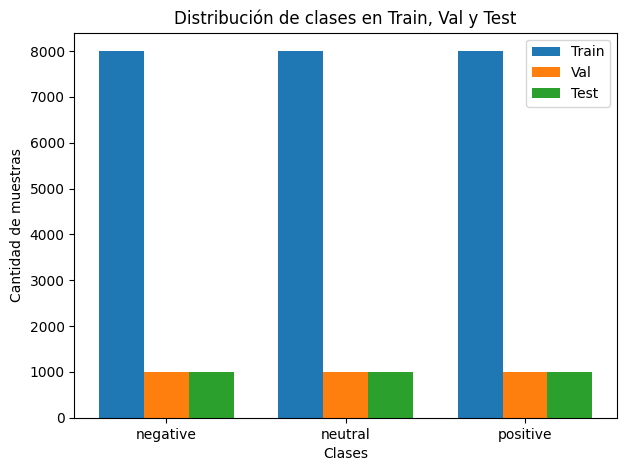

 Imagen guardada en Drive como '01_distribucion_clases.png'


In [5]:
# Contar etiquetas en cada conjunto
counts_train = np.bincount(y_train)
counts_val   = np.bincount(y_val)
counts_test  = np.bincount(y_test)

# Crear gráfico de barras
fig, ax = plt.subplots(figsize=(7,5))
bar_width = 0.25
x = np.arange(len(labels))

ax.bar(x - bar_width, counts_train, width=bar_width, label='Train')
ax.bar(x, counts_val, width=bar_width, label='Val')
ax.bar(x + bar_width, counts_test, width=bar_width, label='Test')

# Configuración de ejes y etiquetas
ax.set_xlabel('Clases')
ax.set_ylabel('Cantidad de muestras')
ax.set_title('Distribución de clases en Train, Val y Test')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.savefig("/content/drive/MyDrive/Proyecto_Grupo4/Results/01_distribucion_clases.png", dpi=300)
plt.show()

print(" Imagen guardada en Drive como '01_distribucion_clases.png'")


Vectorizar con TF‑IDF procesamiento

In [6]:
vectorizer = TfidfVectorizer(max_features=10_000, min_df=2, ngram_range=(1,2))
#max_features controla el tamaño del vocabulario

# Ajustar en train y transformar val/test (se generan matrices dispersas)
# Definimos el vectorizador TF-IDF para convertir texto a vectores numéricos.
X_train_tf = vectorizer.fit_transform(X_train)
X_val_tf   = vectorizer.transform(X_val)
X_test_tf  = vectorizer.transform(X_test)

# Para usar NumPy en la red, convertimos a denso y a float32 optimizar RAM
X_train_np = X_train_tf.toarray().astype(np.float32)
X_val_np   = X_val_tf.toarray().astype(np.float32)
X_test_np  = X_test_tf.toarray().astype(np.float32)

#La redes necesitan que las clases sean enteros (0, 1, 2).
y_train_np = y_train.astype(int)
y_val_np   = y_val.astype(int)
y_test_np  = y_test.astype(int)

#Comprobar tamaños de las matrices
print("Shapes ->",
      "train:", X_train_np.shape,
      "| val:", X_val_np.shape,
      "| test:", X_test_np.shape)

# Estimación aproximada de memoria usada por estos arrays (GB), respetando ram de google colab
def approx_mem_gb(arrs):
    return sum(a.nbytes for a in arrs) / (1024**3)

print(f"Memoria aprox. (GB): {approx_mem_gb([X_train_np, X_val_np, X_test_np]):.2f}") #Para que colab funcione correctamente

Shapes -> train: (24000, 10000) | val: (3000, 10000) | test: (3000, 10000)
Memoria aprox. (GB): 1.12


Red Neuronal en NumPy

In [7]:
# Red Neuronal NumPy (desde cero)

#Activaciones y derivadas para backprop
ACTS = {
    "relu": (
        # f(z)
        lambda z: np.maximum(0, z).astype(np.float32),
        # f'(z)
        lambda z: (z > 0).astype(np.float32),
    ),
    "tanh": (
        lambda z: np.tanh(z).astype(np.float32),
        lambda z: (1 - np.tanh(z)**2).astype(np.float32),
    ),
    "sigmoid": (
        lambda z: (1/(1+np.exp(-z))).astype(np.float32),
        lambda z: (1/(1+np.exp(-z))) * (1 - (1/(1+np.exp(-z))))
    ),
}

def one_hot(y, n_classes):
    """
    Convierte etiquetas enteras (0..K-1) a one-hot (B, K).
    """
    oh = np.zeros((y.shape[0], n_classes), dtype=np.float32)
    oh[np.arange(y.shape[0]), y] = 1.0
    return oh


class NeuralNetwork:
    """
    MLP desde cero:
    - Arquitectura ≥2 ocultas recomendada (p. ej. [input, 256, 128, K])
    - Inicialización: He para ReLU en ocultas | Xavier para otras (y salida)
    - Pérdida: cross-entropy + L2 opcional
    - Entrenamiento: SGD mini-batch + early stopping (val_loss)
    """

    # MLP con ≥ 2 capas ocultas; inicialización He/Xavier, softmax en salida.
    # layers: [input_dim, h1, h2, ..., n_classes]
    # activation: 'relu' | 'tanh' | 'sigmoid' (para capas ocultas)
    def __init__(self, layers, activation="relu"):
        assert len(layers) >= 4, "Se recomienda ≥2 capas ocultas: [input, h1, h2, ..., out]"
        self.layers = layers
        self.act_name = activation
        self.params = {}
        self._init_params()

    def _init_params(self):
        """
        He para ReLU en ocultas; Xavier para otras (incluye capa de salida).
        """
        for l in range(1, len(self.layers)):
            fan_in, fan_out = self.layers[l-1], self.layers[l]
            # Ocultas con ReLU -> He; lo demás -> Xavier
            if l < len(self.layers)-1 and self.act_name == "relu":
                W = (np.random.randn(fan_in, fan_out).astype(np.float32) * np.sqrt(2.0/fan_in))
            else:
                limit = np.sqrt(6.0/(fan_in+fan_out))
                W = np.random.uniform(-limit, limit, (fan_in, fan_out)).astype(np.float32)
            b = np.zeros((1, fan_out), dtype=np.float32)
            self.params[f"W{l}"] = W
            self.params[f"b{l}"] = b

    @staticmethod
    def softmax(z):
        """
        Softmax estable por filas (resta el máximo).
        """
        z = z - z.max(axis=1, keepdims=True)
        e = np.exp(z, dtype=np.float32)
        return e / (e.sum(axis=1, keepdims=True) + 1e-12)

    def forward(self, X):
        """
        Forward capa a capa.
        Devuelve:
          probs: salida softmax (B, K)
          caches: lista de (A_prev, Z, W, b) por capa (para backprop)
          last: tupla de la última oculta (A_prev, W_L, b_L) para gradiente de salida
        """
        A = X.astype(np.float32)
        caches = []
        act, dact = ACTS[self.act_name]

        # Capas ocultas
        for l in range(1, len(self.layers)-1):
            W, b = self.params[f"W{l}"], self.params[f"b{l}"]
            Z = A @ W + b
            A = act(Z)
            caches.append((A, Z, W, b))

        # Capa de salida (lineal -> softmax)
        L = len(self.layers) - 1
        W, b = self.params[f"W{L}"], self.params[f"b{L}"]
        logits = A @ W + b
        probs = self.softmax(logits)
        last = (A, W, b)
        return probs, caches, (A, W, b)

    def fit(
        self, X, y, lr=0.03, epochs=20, batch_size=256,
        X_val=None, y_val=None, weight_decay=0.0,  # L2 opcional
        patience=5, verbose=True
    ):
        """
        Entrena con SGD mini-batch. Añade:
          - weight_decay (L2) en gradientes y pérdida
          - val_loss y val_f1 (macro)
          - early stopping basado en val_loss
        """
        n, n_classes = X.shape[0], self.layers[-1]
        y_oh = one_hot(y, n_classes)
        history = {"loss": [], "val_acc": [], "val_f1": [], "val_loss": []}
        act, dact = ACTS[self.act_name]

        best_val = np.inf
        wait = 0
        best_params = None

        for ep in range(1, epochs+1):
            idx = np.random.permutation(n)
            Xb, yb, y_ohb = X[idx], y[idx], y_oh[idx]

            # SGD por mini-lotes
            for i in range(0, n, batch_size):
                X_batch = Xb[i:i+batch_size]; y_batch = y_ohb[i:i+batch_size]

                # --- Forward ---
                probs, caches, last = self.forward(X_batch)

                # --- Gradiente en salida (CE + softmax): dL/dlogits = (probs - y) / B ---
                grad = (probs - y_batch) / max(1, len(X_batch))

                # --- Backprop en salida ---
                A_prev, W_L, b_L = last
                dW = A_prev.T @ grad
                db = grad.sum(axis=0, keepdims=True)

                # L2 (weight decay) en gradiente de W
                if weight_decay > 0:
                    dW += 2.0 * weight_decay * self.params[f"W{len(self.layers)-1}"]

                # Paso de actualización
                self.params[f"W{len(self.layers)-1}"] -= lr * dW
                self.params[f"b{len(self.layers)-1}"] -= lr * db

                # --- Backprop en ocultas ---
                dA = grad @ self.params[f"W{len(self.layers)-1}"].T
                for l in range(len(self.layers)-2, 0, -1):
                    A_l, Z_l, W_l, b_l = caches[l-1]
                    A_prev = X_batch if l == 1 else caches[l-2][0]
                    dZ = dA * dact(Z_l)
                    dW = A_prev.T @ dZ
                    db = dZ.sum(axis=0, keepdims=True)

                    if weight_decay > 0:
                        dW += 2.0 * weight_decay * self.params[f"W{l}"]

                    # Update
                    self.params[f"W{l}"] -= lr * dW
                    self.params[f"b{l}"] -= lr * db

                    if l > 1:
                        dA = dZ @ self.params[f"W{l}"].T

            # --- Métricas al final de cada época ---
            probs_train, _, _ = self.forward(X)
            # Pérdida CE promedio + L2 (opcional)
            ce = -np.mean(np.log(probs_train[np.arange(n), y] + 1e-12))
            if weight_decay > 0:
                l2_sum = sum((self.params[k]**2).sum() for k in self.params if k.startswith("W"))
                ce += weight_decay * l2_sum / n
            history["loss"].append(ce)

            # Validación
            if X_val is not None and y_val is not None:
                probs_val, _, _ = self.forward(X_val)
                # val_loss (para early stopping)
                ce_val = -np.mean(np.log(probs_val[np.arange(len(y_val)), y_val] + 1e-12))
                if weight_decay > 0:
                    l2_sumv = sum((self.params[k]**2).sum() for k in self.params if k.startswith("W"))
                    ce_val += weight_decay * l2_sumv / len(y_val)
                history["val_loss"].append(ce_val)

                y_pred = probs_val.argmax(axis=1)
                val_acc = (y_pred == y_val).mean()
                # 🔸 Añadimos F1 macro (rúbrica Parte 2)
                val_f1 = f1_score(y_val, y_pred, average="macro")
                history["val_acc"].append(val_acc)
                history["val_f1"].append(val_f1)

                # Early stopping en val_loss
                if ce_val + 1e-6 < best_val:
                    best_val = ce_val
                    best_params = {k: v.copy() for k, v in self.params.items()}
                    wait = 0
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"[EarlyStopping] epoch {ep}/{epochs}  val_loss={ce_val:.4f}") #MEjora calidad del entrenamiento y evit sobreajuste
                        if best_params is not None:
                            self.params = best_params
                        break

            if verbose:
                msg = f"[NN {self.act_name}] epoch {ep}/{epochs} - loss={ce:.4f}"
                if X_val is not None:
                    msg += f" - val_loss={history['val_loss'][-1]:.4f} - val_acc={history['val_acc'][-1]:.4f} - val_f1={history['val_f1'][-1]:.4f}"
                print(msg)

        return history

    def predict(self, X):
        probs, _, _ = self.forward(X)
        return probs.argmax(axis=1)


In [8]:
# Dimensiones de entrada/salida a partir de los arrays TF-IDF ya creados
input_dim = X_train_np.shape[1]         # nº de features TF-IDF
n_classes = len(labels)                 # debería ser 3 (negative, neutral, positive)

# Arquitectura con ≥ 2 capas ocultas (rúbrica)
layers = [input_dim, 256, 128, n_classes]

# Instanciamos la red (usa ReLU y nuestra inicialización He/Xavier)
nn = NeuralNetwork(layers=layers, activation="relu")

# Entrenamiento con early stopping (patience) y L2 (weight_decay)
t0 = time()
hist = nn.fit(
    X_train_np, y_train_np,
    lr=0.03,               # puedes experimentar 0.02/0.01 en el Notebook 02
    epochs=20,             # aumenta si aún no converge
    batch_size=256,
    X_val=X_val_np, y_val=y_val_np,
    weight_decay=1e-4,     # L2 leve (regularización)
    patience=3,            # early stopping si no mejora val_loss
    verbose=True
)
t_train = time() - t0
print(f"Tiempo entrenando: {t_train:.1f}s")

# Métricas en VALIDACIÓN (accuracy + F1 macro)
#    - Si tu fit ya guarda val_f1 en hist, lo usamos; si no, lo calculamos aquí.
if "val_f1" in hist and len(hist["val_f1"]) > 0:
    val_f1 = hist["val_f1"][-1]
else:
    y_val_pred = nn.predict(X_val_np)
    val_f1 = f1_score(y_val_np, y_val_pred, average="macro")

if "val_acc" in hist and len(hist["val_acc"]) > 0:
    val_acc = hist["val_acc"][-1]
else:
    y_val_pred = nn.predict(X_val_np)
    val_acc = (y_val_pred == y_val_np).mean()

print(f"Validación -> acc: {val_acc:.4f} | F1(macro): {val_f1:.4f}")

# Métricas en TEST (obligatorias para informe)
y_test_pred = nn.predict(X_test_np)
test_acc = accuracy_score(y_test_np, y_test_pred)
test_f1  = f1_score(y_test_np, y_test_pred, average="macro")
print(f"Test -> acc: {test_acc:.4f} | F1(macro): {test_f1:.4f}\n")

print("Reporte por clase (TEST):")
print(classification_report(y_test_np, y_test_pred, digits=4, target_names=labels))
cm = confusion_matrix(y_test_np, y_test_pred, labels=[0,1,2])
print("Matriz de confusión (TEST):\n", cm)

# Guardar artefactos para los Notebooks 02/03
save_dir = "/content/drive/MyDrive/Proyecto_Grupo4/Results"
os.makedirs(save_dir, exist_ok=True)

#performance_comparaciones.csv → agregamos esta corrida
perf_row = pd.DataFrame([{
    "model": "nn",
    "arch": str([256, 128]),
    "activation": "relu",
    "lr": 0.03,
    "epochs": 20,
    "batch_size": 256,
    "wd": 1e-4,
    "val_acc": float(val_acc),
    "val_f1":  float(val_f1),
    "train_time_s": round(t_train, 1),
    "test_acc": float(test_acc),
    "test_f1":  float(test_f1)
}])

perf_path = f"{save_dir}/01_performance_comparaciones.csv"
if os.path.exists(perf_path):
    prev = pd.read_csv(perf_path)
    perf_all = pd.concat([prev, perf_row], ignore_index=True)
else:
    perf_all = perf_row
perf_all.to_csv(perf_path, index=False)
print("Guardado:", perf_path)

# test_predictions.csv → y_true / y_pred del TEST (para matriz de confusión)
preds_path = f"{save_dir}/01_test_predictions.csv"
pd.DataFrame({"y_true": y_test_np, "y_pred": y_test_pred}).to_csv(preds_path, index=False)
print("Guardado:", preds_path)

[NN relu] epoch 1/20 - loss=1.0970 - val_loss=1.0972 - val_acc=0.3887 - val_f1=0.3845
[NN relu] epoch 2/20 - loss=1.0949 - val_loss=1.0952 - val_acc=0.4313 - val_f1=0.4315
[NN relu] epoch 3/20 - loss=1.0919 - val_loss=1.0924 - val_acc=0.4677 - val_f1=0.4289
[NN relu] epoch 4/20 - loss=1.0880 - val_loss=1.0888 - val_acc=0.4740 - val_f1=0.4406
[NN relu] epoch 5/20 - loss=1.0830 - val_loss=1.0840 - val_acc=0.5027 - val_f1=0.4849
[NN relu] epoch 6/20 - loss=1.0771 - val_loss=1.0783 - val_acc=0.5203 - val_f1=0.4617
[NN relu] epoch 7/20 - loss=1.0698 - val_loss=1.0714 - val_acc=0.5550 - val_f1=0.5349
[NN relu] epoch 8/20 - loss=1.0614 - val_loss=1.0633 - val_acc=0.5813 - val_f1=0.5806
[NN relu] epoch 9/20 - loss=1.0513 - val_loss=1.0537 - val_acc=0.5800 - val_f1=0.5701
[NN relu] epoch 10/20 - loss=1.0390 - val_loss=1.0419 - val_acc=0.5863 - val_f1=0.5615
[NN relu] epoch 11/20 - loss=1.0242 - val_loss=1.0278 - val_acc=0.5977 - val_f1=0.5811
[NN relu] epoch 12/20 - loss=1.0072 - val_loss=1.011

Softmax-Regresión logística

In [9]:
# BASELINE: Regresión Softmax (Logística Multiclase)
# ==========================================================
# Modelo lineal simple: y = softmax(XW + b)
# Sirve de línea base para comparar contra la red neuronal.
import numpy as np
from sklearn.metrics import f1_score

class SoftmaxRegression:
    def __init__(self, input_dim, n_classes=3):
        """
        Inicialización Xavier (uniforme) para estabilidad.
        input_dim: nº de features (TF-IDF)
        n_classes: nº de clases (neg/neu/pos -> 3)
        """
        limit = np.sqrt(6.0 / (input_dim + n_classes))
        self.W = np.random.uniform(-limit, limit, (input_dim, n_classes)).astype(np.float32)
        self.b = np.zeros((1, n_classes), dtype=np.float32)

    @staticmethod
    def softmax(z):
        """Softmax estable por filas (evita overflow)."""
        z = z - z.max(axis=1, keepdims=True)
        e = np.exp(z, dtype=np.float32)
        return e / (e.sum(axis=1, keepdims=True) + 1e-12)

    def forward(self, X):
        """Devuelve probabilidades por clase."""
        return self.softmax(X @ self.W + self.b)

    def predict(self, X):
        """Clase predicha por argmax."""
        return self.forward(X).argmax(axis=1)

    def fit(
        self, X, y, lr=0.2, epochs=8, batch_size=512,
        X_val=None, y_val=None,
        weight_decay=1e-4,       # L2 (0.0 para desactivar)
        patience=3,              # early stopping por val_loss
        verbose=True
    ):
        """
        Entrenamiento SGD mini-batch con:
        - Pérdida: cross-entropy + L2
        - Historial: loss, val_loss, val_acc, val_f1
        - Early stopping en val_loss
        """
        n, K = X.shape[0], self.b.shape[1]
        y_oh = np.eye(K, dtype=np.float32)[y]

        history = {"loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
        best_val, wait = np.inf, 0
        best_params = None

        for ep in range(1, epochs+1):
            # Barajar
            idx = np.random.permutation(n)
            Xb, yb, y_ohb = X[idx], y[idx], y_oh[idx]

            # Mini-batches
            for i in range(0, n, batch_size):
                X_batch = Xb[i:i+batch_size]
                y_batch = y_ohb[i:i+batch_size]

                # Forward
                probs = self.forward(X_batch)

                # Gradientes (CE + softmax)
                grad_logits = (probs - y_batch) / max(1, len(X_batch))
                dW = X_batch.T @ grad_logits
                db = grad_logits.sum(axis=0, keepdims=True)

                # L2 (weight decay) en gradiente
                if weight_decay > 0:
                    dW += 2.0 * weight_decay * self.W

                # Paso de actualización
                self.W -= lr * dW
                self.b -= lr * db

            # ---- Métricas por época (train) ----
            probs_train = self.forward(X)
            ce = -np.mean(np.log(probs_train[np.arange(n), y] + 1e-12))
            if weight_decay > 0:
                ce += weight_decay * (self.W**2).sum() / n
            history["loss"].append(ce)

            # ---- Validación + Early Stopping ----
            if X_val is not None and y_val is not None:
                probs_val = self.forward(X_val)
                ce_val = -np.mean(np.log(probs_val[np.arange(len(y_val)), y_val] + 1e-12))
                if weight_decay > 0:
                    ce_val += weight_decay * (self.W**2).sum() / len(y_val)
                history["val_loss"].append(ce_val)

                y_val_pred = probs_val.argmax(axis=1)
                val_acc = (y_val_pred == y_val).mean()
                val_f1  = f1_score(y_val, y_val_pred, average="macro")
                history["val_acc"].append(val_acc)
                history["val_f1"].append(val_f1)

                # Early stopping en val_loss
                if ce_val + 1e-6 < best_val:
                    best_val, wait = ce_val, 0
                    best_params = (self.W.copy(), self.b.copy())
                else:
                    wait += 1
                    if wait >= patience:
                        if verbose:
                            print(f"[Softmax][EarlyStopping] epoch {ep}/{epochs}  val_loss={ce_val:.4f}")
                        if best_params is not None:
                            self.W, self.b = best_params
                        break

            if verbose:
                msg = f"[Softmax] ep {ep}/{epochs}"
                if history["val_acc"]:
                    msg += f" | val_acc: {history['val_acc'][-1]:.4f} | val_f1: {history['val_f1'][-1]:.4f}"
                print(msg)

        return history

Entrenar Baseline

In [10]:
# Creamos el modelo
sm = SoftmaxRegression(
    input_dim=X_train_np.shape[1],
    n_classes=3
)

# Entrenamos
history_sm = sm.fit(
    X_train_np, y_train_np,
    lr=0.2,
    epochs=8,
    batch_size=512,
    X_val=X_val_np, y_val=y_val_np,
    weight_decay=1e-4,
    patience=3,
    verbose=True
)


[Softmax] ep 1/8 | val_acc: 0.4503 | val_f1: 0.4142
[Softmax] ep 2/8 | val_acc: 0.5440 | val_f1: 0.5413
[Softmax] ep 3/8 | val_acc: 0.5490 | val_f1: 0.5377
[Softmax] ep 4/8 | val_acc: 0.5820 | val_f1: 0.5844
[Softmax] ep 5/8 | val_acc: 0.5910 | val_f1: 0.5936
[Softmax] ep 6/8 | val_acc: 0.6050 | val_f1: 0.6062
[Softmax] ep 7/8 | val_acc: 0.6053 | val_f1: 0.6004
[Softmax] ep 8/8 | val_acc: 0.6180 | val_f1: 0.6206


 Evaluar en TEST: NN vs Softmax

 NeuralNet -> acc: 0.6313 | F1(macro): 0.6285
Classification report:
               precision    recall  f1-score   support

    negative     0.6914    0.6520    0.6711      1000
     neutral     0.5188    0.4830    0.5003      1000
    positive     0.6741    0.7590    0.7140      1000

    accuracy                         0.6313      3000
   macro avg     0.6281    0.6313    0.6285      3000
weighted avg     0.6281    0.6313    0.6285      3000



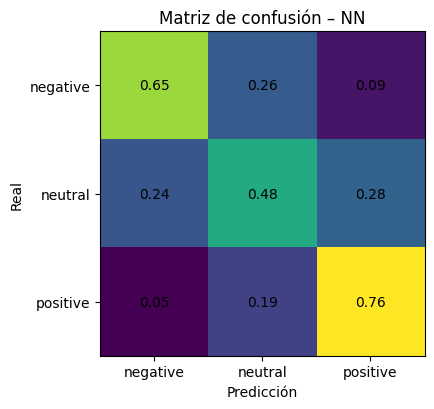

 Softmax -> acc: 0.6040 | F1(macro): 0.6067
Classification report:
               precision    recall  f1-score   support

    negative     0.6618    0.6360    0.6486      1000
     neutral     0.4956    0.5620    0.5267      1000
    positive     0.6785    0.6140    0.6446      1000

    accuracy                         0.6040      3000
   macro avg     0.6120    0.6040    0.6067      3000
weighted avg     0.6120    0.6040    0.6067      3000



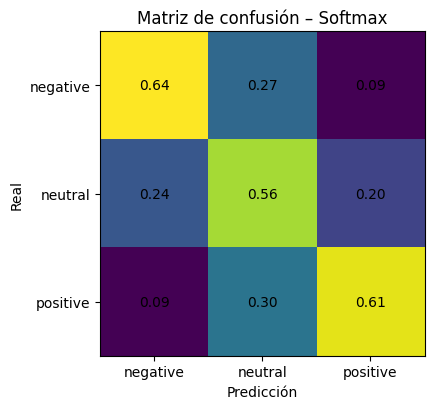

Comparativo (TEST) guardado en: /content/drive/MyDrive/Proyecto_Grupo4/Results/01_performance_top2_test.csv
01_performance_comparaciones.csv actualizado: /content/drive/MyDrive/Proyecto_Grupo4/Results/01_performance_comparaciones.csv
 Predicciones de TEST guardadas.


In [11]:
# Evaluación (NN y Softmax)a
# Guarda PNGs y actualiza performance_comparaciones.csv

# Comprobaciones mínimas
assert 'nn' in globals(), "No encuentro el modelo 'nn'. Ejecuta la celda de entrenamiento de la NN."
assert 'X_test_np' in globals() and 'y_test_np' in globals(), "Faltan X_test_np / y_test_np."

labels = ["negative","neutral","positive"]
save_dir = "/content/drive/MyDrive/Proyecto_Grupo4/Results"
os.makedirs(save_dir, exist_ok=True)

def eval_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f" {name} -> acc: {acc:.4f} | F1(macro): {f1m:.4f}")
    print("Classification report:\n",
          classification_report(y_true, y_pred, digits=4, target_names=labels))
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    return acc, f1m, cm

def plot_cm_normalized(cm, title, path_png):
    # Normalizamos por fila (proporción por clase real)
    M = cm.astype(np.float32)
    M = M / M.sum(axis=1, keepdims=True).clip(min=1)

    fig, ax = plt.subplots(figsize=(5.2,4.2))
    im = ax.imshow(M)
    ax.set_title(title)
    ax.set_xticks(range(3)); ax.set_xticklabels(labels)
    ax.set_yticks(range(3)); ax.set_yticklabels(labels)

    # mostramos porcentaje con dos decimales
    for i in range(3):
        for j in range(3):
            ax.text(j, i, f"{M[i,j]:.2f}", ha="center", va="center")

    ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
    plt.tight_layout()
    plt.savefig(path_png, dpi=300)
    plt.show()

rows = []

#NN
y_pred_nn = nn.predict(X_test_np)
acc_nn, f1_nn, cm_nn = eval_model("NeuralNet", y_test_np, y_pred_nn)
plot_cm_normalized(cm_nn, "Matriz de confusión – NN",
                   f"{save_dir}/01_cm_nn.png")
arch_nn = str(layers[1:-1]) if 'layers' in globals() else "[256,128]"
rows.append({"model":"nn","arch":arch_nn,"activation":"relu","test_acc":acc_nn,"test_f1":f1_nn})

# Softmax
if 'sm' in globals():
    y_pred_sm = sm.predict(X_test_np)
    acc_sm, f1_sm, cm_sm = eval_model("Softmax", y_test_np, y_pred_sm)
    plot_cm_normalized(cm_sm, "Matriz de confusión – Softmax",
                       f"{save_dir}/01_cm_sm.png")
    rows.append({"model":"softmax","arch":"linear","activation":"softmax","test_acc":acc_sm,"test_f1":f1_sm})
else:
    print("Nota: no encontré 'sm'. Si quieres comparar baseline, entrena Softmax y vuelve a ejecutar.")

# Guardar comparativo TEST
df_comp = pd.DataFrame(rows)
comp_path = f"{save_dir}/01_performance_top2_test.csv"
df_comp.to_csv(comp_path, index=False)
print("Comparativo (TEST) guardado en:", comp_path)

#Actualizar performance_comparaciones.csv --------
perf_path = f"{save_dir}/01_performance_comparaciones.csv"
if os.path.exists(perf_path):
    prev = pd.read_csv(perf_path)
    cols = sorted(set(prev.columns) | set(df_comp.columns))
    merged = pd.concat([prev.reindex(columns=cols), df_comp.reindex(columns=cols)], ignore_index=True)
else:
    merged = df_comp
merged.to_csv(perf_path, index=False)
print("01_performance_comparaciones.csv actualizado:", perf_path)

# predicciones de TEST (útil para Notebook 03)
pd.DataFrame({"model":"nn","y_true":y_test_np,"y_pred":y_pred_nn}).to_csv(f"{save_dir}/01_test_predictions_nn.csv", index=False)
if 'sm' in globals():
    pd.DataFrame({"model":"softmax","y_true":y_test_np,"y_pred":y_pred_sm}).to_csv(f"{save_dir}/01_test_predictions_softmax.csv", index=False)
print(" Predicciones de TEST guardadas.")


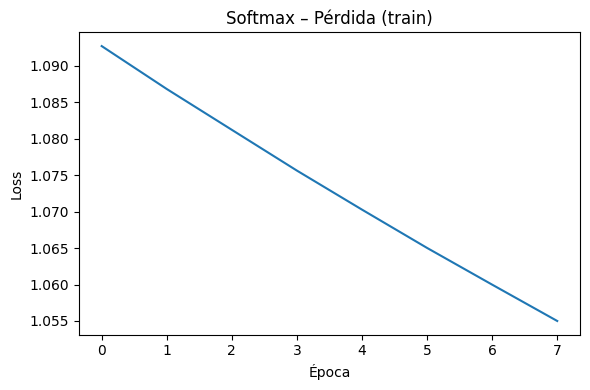

Guardado: /content/drive/MyDrive/Proyecto_Grupo_4/Results/01_sm_loss.png


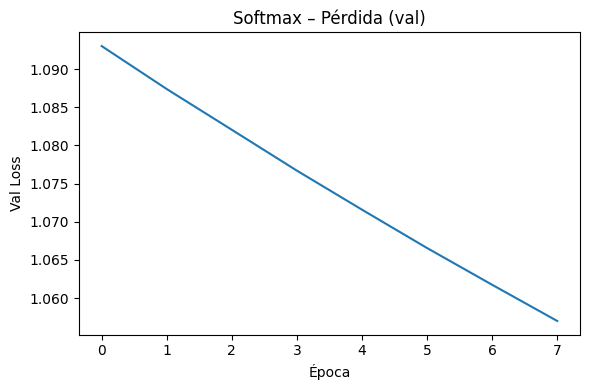

Guardado: /content/drive/MyDrive/Proyecto_Grupo_4/Results/01_sm_val_loss.png


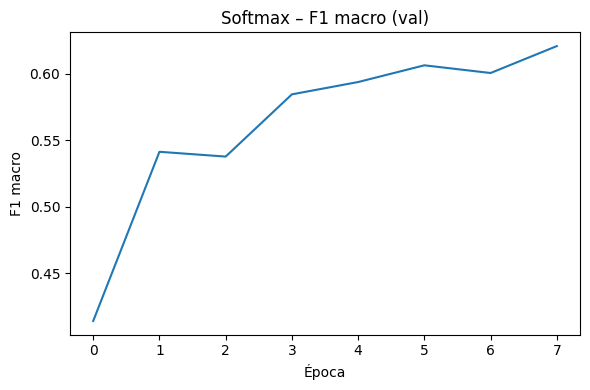

Guardado: /content/drive/MyDrive/Proyecto_Grupo_4/Results/01_sm_val_f1.png


In [12]:
#Crear y Guardar curva de entrenamiento
save_dir = "/content/drive/MyDrive/Proyecto_Grupo_4/Results"
os.makedirs(save_dir, exist_ok=True)

def plot_curve(vals, title, ylabel, filename):
    if not vals:
        print(f"(sin datos) {title}")
        return
    plt.figure(figsize=(6,4))
    plt.plot(vals)
    plt.title(title); plt.xlabel("Época"); plt.ylabel(ylabel)
    plt.tight_layout(); plt.savefig(f"{save_dir}/{filename}", dpi=300); plt.show()
    print("Guardado:", f"{save_dir}/{filename}")

# NN
if 'history' in globals():
    plot_curve(history.get("loss", []),    "NN – Pérdida (train)", "Loss", "01_nn_loss.png")
    plot_curve(history.get("val_loss", []),"NN – Pérdida (val)",   "Val Loss", "01_nn_val_loss.png")
    plot_curve(history.get("val_f1", []),  "NN – F1 macro (val)",  "F1 macro", "01_nn_val_f1.png")

# Softmax
if 'history_sm' in globals():
    plot_curve(history_sm.get("loss", []),    "Softmax – Pérdida (train)", "Loss", "01_sm_loss.png")
    plot_curve(history_sm.get("val_loss", []),"Softmax – Pérdida (val)",   "Val Loss", "01_sm_val_loss.png")
    plot_curve(history_sm.get("val_f1", []),  "Softmax – F1 macro (val)",  "F1 macro", "01_sm_val_f1.png")



In [13]:
# Comparación y guardar resultados como csv
rows = []

# --- Neural Network ---
if 'y_pred_nn' in globals():
    rows.append({
        "model": "NeuralNetwork",
        "acc": accuracy_score(y_test_np, y_pred_nn),
        "f1_macro": f1_score(y_test_np, y_pred_nn, average="macro"),
        "layers": str([X_train_np.shape[1], 256, 128, 3]),
        "activation": "relu",
        "lr": 0.03,
        "batch_size": 256,
        "max_features": 10_000
    })
else:
    print("No se encontró y_pred_nn. Asegúrate de entrenar la red neuronal antes.")

# --- Softmax ---
if 'y_pred_sm' in globals():
    rows.append({
        "model": "Softmax",
        "acc": accuracy_score(y_test_np, y_pred_sm),
        "f1_macro": f1_score(y_test_np, y_pred_sm, average="macro"),
        "layers": "linear",
        "activation": "softmax",
        "lr": 0.2,
        "batch_size": 512,
        "max_features": 10_000
    })
else:
    print("No se encontró y_pred_sm. Asegúrate de entrenar el modelo Softmax antes.")
#Guardar
if rows:
    df_perf = pd.DataFrame(rows)

    # Ruta
    save_dir = "/content/drive/MyDrive/Proyecto_Grupo_4/Results"

    out_path = f"{save_dir}/01_performance_comparison.csv"
    df_perf.to_csv(out_path, index=False)

    print(f"Resultados guardados en {out_path}")
    display(df_perf)
else:
    print("No se guardó ningún resultado porque no hay modelos evaluados.")

Resultados guardados en /content/drive/MyDrive/Proyecto_Grupo_4/Results/01_performance_comparison.csv


,model,acc,f1_macro,layers,activation,lr,batch_size,max_features
0,NeuralNetwork,0.631333,0.628468,"[10000, 256, 128, 3]",relu,0.03,256,10000
1,Softmax,0.604000,0.606659,linear,softmax,0.20,512,10000


In [14]:
# Predicciones

def show_samples(X_raw, y_true, y_pred, n=5):
    idx = np.random.choice(len(X_raw), size=n, replace=False)
    for i in idx:
        print("—"*60)
        print("Texto:", X_raw[i][:300].replace("\n"," "))
        print("Real:", labels[y_true[i]], "| Pred:", labels[y_pred[i]])

labels = ["negative","neutral","positive"]
# Para NN (Red neuronal):
show_samples(X_test, y_test_np, y_pred_nn, n=5)


————————————————————————————————————————————————————————————
Texto: We have this on our boat. It had help up to exposure to salt water. It works very well for a small radio. transmits and receives messages very clearly. It is easy to use at night as well.
Real: positive | Pred: positive
————————————————————————————————————————————————————————————
Texto: This works at bringing in the signal into my condo. Where I once had one "bar" I now have three, but the problem is that I only covers the two front rooms. My bedrooms past the kitchen have zero signal. It doesn't go very far. I'll be calling customer service to see what the solution is. It doesn't 
Real: neutral | Pred: neutral
————————————————————————————————————————————————————————————
Texto: Received this product very fast which was excellent news. I have 4 external HDD, Wireless Mouse and Keyboards (with USB wireless sensors), my Treo HotSynch cable and Flash drive all hooked to this Hub and to my laptop. Purring perfectly without 

# Conclusiones (Notebook 01 — Implementación)

* **Datos**
  * Total usado: ~30k (10k/clase). Split 80/10/10.
  * TF‑IDF: max_features=10 000, ngram_range=(1,2).

* Rendimiento comparativo
Softmax (baseline) obtuvo mejor rendimiento que la red neuronal:

  * Accuracy: 0.6020 vs 0.4727

  * F1-macro: 0.6023 vs 0.4669

Esto indica que, en este caso, un modelo lineal simple se ajustó mejor al problema que la arquitectura de NN utilizada, la posible causa la NN no logró generalizar bien por configuración de hiperparámetros, arquitectura no óptima o falta de datos para entrenar tantas capas.

* Patrones observados por clase
  * Negative: mejor clasificada por Softmax (precisión y recall > 0.65) que por NN (recall 0.39).

  * Neutral: ambas arquitecturas tienen dificultad, pero Softmax la maneja mejor (recall 0.50 vs 0.38).

  * Positive: NN tuvo un recall alto (0.64) pero sacrificando las demás clases. Softmax mantiene buen equilibrio.

* Recomendaciones
  * Ajustar hiperparámetros de la NN (learning rate, número de neuronas, regularización, dropout).

  * Aumentar épocas con early stopping y optimizador más estable (Adam).

**Próximos pasos (para 02_experimentacion)**
- Probar activaciones ReLU vs Tanh.
- Variar capas: [128,64] / [256,128,64].
- Learning rates: 0.02 / 0.03 / 0.05.
- Guardar comparaciones en `results/performance_comparison.csv`.
